# Baseline model

Here we will train the same model used in our network, but without federated learning. This will give us a good baseline to compare against  

This model is trained on the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html), which consists of 60000 32x32 colour images split into 10 classes. Each class has 6000 images.

In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import torch

from src.models.utils.environment import get_device
DEVICE = get_device(cpu=False)

In [6]:
print(f"Cuda available: {torch.cuda.is_available()}")

try:
    print(f"major and minor cuda capability of the device: {torch.cuda.get_device_capability()}")
except Exception:
    print("No Cuda available")

Cuda available: True
major and minor cuda capability of the device: (8, 6)


Create the model

In [10]:
from src.models.simple_cnn import create_model
from src.models.utils import count_parameters

net = create_model(in_channels=3, img_size=32, device=DEVICE)
print(count_parameters(net, breakdown=True))
print(f"Total Parameters: {count_parameters(net):,}")

          module  parameters
0  conv.0.weight         450
1    conv.0.bias           6
2  conv.3.weight        2400
3    conv.3.bias          16
4    fc.0.weight      262144
5      fc.0.bias         256
6    fc.2.weight       32768
7      fc.2.bias         128
8    fc.4.weight        1280
9      fc.4.bias          10
Total Parameters: 299,458


We'll load the CIFAR-10 dataset here

In [11]:
from src.datasets import cifar10_noniid, cifar10_test

trainloader, validloader = cifar10_noniid()
testloader = cifar10_test()

Files already downloaded and verified
Files already downloaded and verified


Now train the model

Note that we'll train the model for the same number of epochs as rounds are performed in FL

In [12]:
from opacus import PrivacyEngine

from src.models.evaluation.train_cls import train
from src.utils.constants import DEFAULT_LOCAL_EPOCHS, DEFAULT_FL_ROUNDS

epochs = DEFAULT_LOCAL_EPOCHS * DEFAULT_FL_ROUNDS
privacy_engine = PrivacyEngine()
loss_vals = train(net, trainloader, epochs, privacy_engine=privacy_engine, device=DEVICE)

/home/evan/Projects/school/Sharded-Committee-Consensus-in-Blockchain-based-Federated-Learning/example-participant/fl-service/.venv/lib/python3.9/site-packages/opacus/privacy_engine.py:100: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/home/evan/Projects/school/Sharded-Committee-Consensus-in-Blockchain-based-Federated-Learning/example-participant/fl-service/.venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [13]:
from src.utils.constants import PRIVACY_TARGET_DELTA

privacy_engine.get_epsilon(PRIVACY_TARGET_DELTA)

12.162484285244751

<AxesSubplot:>

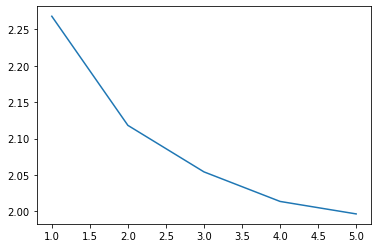

In [14]:
import numpy as np
import seaborn as sns

sns.lineplot(x=np.linspace(1, epochs, epochs), y=loss_vals)

Now we'll evaluate the model

In [15]:
from src.models.evaluation.train_cls import test

loss, accuracy = test(net, testloader, device=DEVICE)

In [16]:
accuracy

0.2923

01/15/2022 05:09:03:WARNING:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
01/15/2022 05:09:03:WARNING:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
01/15/2022 05:09:03:WARNING:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
01/15/2022 05:09:03:WARNING:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
01/15/2022 05:09:03:WARNING:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
01/15/2022 05:09:03:WARNING:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


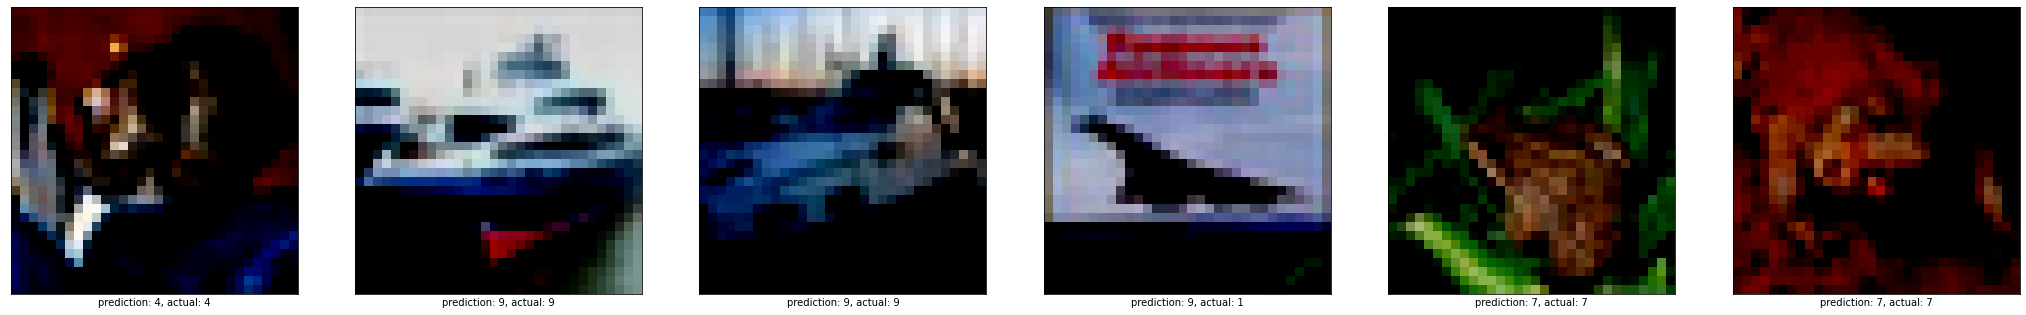

In [17]:
from src.datasets.visualize import show_predictions, MNIST_CLASSES

show_predictions(net, testloader, channels=3, img_size=32, labels=MNIST_CLASSES, device=DEVICE)